# Credit default
__Note on how to use this notebook:__ <br>
1) Save the notebook to disk. <br>
2) Save the [data set](https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls) to the same folder that this notebook was saved in. 

[Data description](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#) <br>




# Abstract

# Introduction

In [1]:
import pandas as pd
import os
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

The following runs the data preperation that is used for all models.

We scale all features by Sci-Kit learn's standard scaler. The standard scalars subtracts the mean, so that the means of the standardized variables equal zero. Furthermore the standard scaler divides the feautres by their respective variances, so that the variances of the standardized features equals one.

In [2]:
# Trying to set the seed
np.random.seed(0)
import random
random.seed(0)

# Reading file into data frame
cwd = os.getcwd()
filename = cwd + '/default of credit card clients.xls'
nanDict = {}
df = pd.read_excel(filename, header=1, skiprows=0, index_col=0, na_values=nanDict)

df.rename(index=str, columns={"default payment next month": "defaultPaymentNextMonth"}, inplace=True)

# Features and targets 
X = df.loc[:, df.columns != 'defaultPaymentNextMonth'].values
y = df.loc[:, df.columns == 'defaultPaymentNextMonth'].values

# Categorical variables to one-hot's
onehotencoder = OneHotEncoder(categorical_features = [3])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:] 

# Train-test split
trainingShare = 0.5 
seed  = 1
XTrain, XTest, yTrain, yTest=train_test_split(X, y, train_size=trainingShare, \
                                              test_size = 1-trainingShare,
                                             random_state=seed)

# Input Scaling
sc = StandardScaler()
XTrain = sc.fit_transform(XTrain)
XTest = sc.transform(XTest)

# One-hot's of the target vector
Y_train_onehot, Y_test_onehot = to_categorical(yTrain), to_categorical(yTest)

# Remove instances with zeros only for past bill statements or paid amounts
'''
df = df.drop(df[(df.BILL_AMT1 == 0) &
                (df.BILL_AMT2 == 0) &
                (df.BILL_AMT3 == 0) &
                (df.BILL_AMT4 == 0) &
                (df.BILL_AMT5 == 0) &
                (df.BILL_AMT6 == 0) &
                (df.PAY_AMT1 == 0) &
                (df.PAY_AMT2 == 0) &
                (df.PAY_AMT3 == 0) &
                (df.PAY_AMT4 == 0) &
                (df.PAY_AMT5 == 0) &
                (df.PAY_AMT6 == 0)].index)
'''
df = df.drop(df[(df.BILL_AMT1 == 0) &
                (df.BILL_AMT2 == 0) &
                (df.BILL_AMT3 == 0) &
                (df.BILL_AMT4 == 0) &
                (df.BILL_AMT5 == 0) &
                (df.BILL_AMT6 == 0)].index)

df = df.drop(df[(df.PAY_AMT1 == 0) &
                (df.PAY_AMT2 == 0) &
                (df.PAY_AMT3 == 0) &
                (df.PAY_AMT4 == 0) &
                (df.PAY_AMT5 == 0) &
                (df.PAY_AMT6 == 0)].index)

# Descriptive information
print('Number of empty elements in data: ', df.isnull().values.any())
print('Observations: ', df.shape[0])
print('Percentage defaults: ', df['defaultPaymentNextMonth'].astype(bool).sum(axis=0)/df.shape[0]*100)

Number of empty elements in data:  False
Observations:  28497
Percentage defaults:  21.31452433589501


This is not the same number of observations as in Yeh and Lien (2009). Yeh and Lien (2009) have 25 000 observations. However, we have the same number of observations as in Pyzhov and Pyzhov (2017), which is said to use the same dataset as Yeh and Lien (2009). 

The percentage of individuals with default is the same as in the Yeh and Lien (2009).


# Results
Explanations and grid searches on the different models will be performed before the model performances are discussed.
The different methods will be explained when they are used. Grid searches are applied to all methods. The grid search results are discussed where they are produced. 

## Logistic regression
We apply Sci-Kit learn's logistic regression method for performing classification of default and non-defaulting customers. It is possible to use regularization for the logistic regression. Regularization has the potential to reduce overfitting. We will apply Sci-Kit learn's Grid search function for identifying the optimal regularization value. The optimal regularization parameter is determined by the AUC on test sets applying K-fold cross validation.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lmbdas=np.logspace(-5,7,13)
parameters = [{'C': 1./lmbdas}]
scoring = ['accuracy', 'roc_auc']
logReg = LogisticRegression()
gridSearch = GridSearchCV(logReg, parameters, cv=5, scoring=scoring, refit='roc_auc') 
# "refit" gives the metric used deciding best model. 
# See more http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
gridSearch.fit(XTrain, yTrain.ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': array([1.e+05, 1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02,
       1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07])}],
       pre_dispatch='2*n_jobs', refit='roc_auc', return_train_score='warn',
       scoring=['accuracy', 'roc_auc'], verbose=0)

In [4]:
def gridSearchSummary(method, scoring):
    """Prints best parameters from Grid search
    and AUC with standard deviation for all 
    parameter combos """
    
    method = eval(method)
    if scoring == 'accuracy':
        mean = 'mean_test_score'
        sd = 'std_test_score'
    elif scoring == 'auc':
        mean = 'mean_test_roc_auc'
        sd = 'std_test_roc_auc'
    print("Best: %f using %s" % (method.best_score_, method.best_params_))
    means = method.cv_results_[mean]
    stds = method.cv_results_[sd]
    params = method.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [5]:
gridSearchSummary('gridSearch', 'auc')

Best: 0.723594 using {'C': 0.1}
0.723494 (0.008033) with: {'C': 99999.99999999999}
0.723494 (0.008033) with: {'C': 10000.0}
0.723494 (0.008033) with: {'C': 1000.0}
0.723495 (0.008033) with: {'C': 100.0}
0.723496 (0.008036) with: {'C': 10.0}
0.723518 (0.008048) with: {'C': 1.0}
0.723594 (0.008032) with: {'C': 0.1}
0.723440 (0.007838) with: {'C': 0.01}
0.717568 (0.007688) with: {'C': 0.001}
0.705035 (0.007697) with: {'C': 0.0001}
0.699007 (0.007833) with: {'C': 1e-05}
0.698128 (0.007831) with: {'C': 1e-06}
0.698044 (0.007811) with: {'C': 1e-07}


We see that in terms of accuracy it mostly does not matter much what the regularization parameter value is. The difference in test score between the eight first regularization parameter values is practically non-existent.

Create a function for creating and printing accuracy results and confusion matrices.

In [84]:
def createConfusionMatrix(method, printOut=True):
    """
    Computes and prints confusion matrices, accuracy scores,
    and AUC for test and training sets 
    """
    confusionArray = np.zeros(6, dtype=object)
    method = eval(method)
    
    # Train
    yPredTrain = method.predict(XTrain)
    yPredTrain = (yPredTrain > 0.5)
    cm = confusion_matrix(
        yTrain, yPredTrain) 
    cm = np.around(cm/cm.sum(axis=1)[:,None], 2)
    confusionArray[0] = cm
    
    accScore = accuracy_score(yTrain, yPredTrain)
    confusionArray[1] = accScore
    
    AUC = roc_auc_score(yTrain, yPredTrain)
    confusionArray[2] = AUC
    
    if printOut:
        print('\n###################  Training  ###############')
        print('\nTraining Confusion matrix: \n', cm)
        print('\nTraining Accuracy score: \n', accScore)
        print('\nTrain AUC: \n', AUC)
    
    # Test
    yPred = method.predict(XTest)
    yPred = (yPred > 0.5)
    cm = confusion_matrix(
        yTest, yPred) 
    cm = np.around(cm/cm.sum(axis=1)[:,None], 2)
    confusionArray[3] = cm
    
    accScore = accuracy_score(yTest, yPred)
    confusionArray[4] = accScore
    
    AUC = roc_auc_score(yTest, yPred)
    confusionArray[5] = AUC
    
    if printOut:
        print('\n###################  Testing  ###############')
        print('\nTest Confusion matrix: \n', cm)
        print('\nTest Accuracy score: \n', accScore)
        print('\nTestAUC: \n', AUC)    
    
    return confusionArray

In [102]:
confusionArrayLogreg = createConfusionMatrix('gridSearch', printOut=False)

The results of the logistic classifier with optimal regularization will be discussed later.

## Neural networks
We will now perform classification by deep neural networks. Keras is used. 

### Combining Keras and Sci-Kit learn
To this authors knowledge, Keras does not have a grid search method. Hence we will apply Sci-Kit learn's grid search function in order to determine the optimal combination of hyperparameters. In oredr to combine Keras and Sci-Kit learn
we use Keras' KerasClassifier. KerasClassifier creates an object that can be used as estimator input in Sci-Kit learn's GridSearchCV method.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV



def createModel(neurons =50, hiddenLayers = 2):
    model = tf.keras.Sequential()
    neuronsPerLayer = neurons // (hiddenLayers + 1)
    model.add(tf.keras.layers.Dense(neuronsPerLayer, activation='relu', input_dim=XTrain.shape[1]))
    for i in range(hiddenLayers):
        model.add(tf.keras.layers.Dense(neuronsPerLayer, activation='relu'))
    model.add(tf.keras.layers.Dense(Y_train_onehot.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=createModel, verbose=0)

neurons = [20, 50, 100, 200, 300, 400]# 500]
hiddenLayers = [1, 2, 3, 5]
batch_size = [5, 10, 32, 64]##, 40, 60, 80, 100]
parameterGrid = [{'neurons': neurons, 'hiddenLayers': hiddenLayers, 'batch_size': batch_size}]
folds = 3
#scoring = ['accuracy', 'roc_auc']
scoring = 'roc_auc'
#grid = GridSearchCV(estimator=model, cv=folds, param_grid=parameterGrid, n_jobs=-1)
#grid = GridSearchCV(estimator=model, cv=folds, param_grid=parameterGrid, n_jobs=-1, scoring=scoring, refit='roc_auc')
grid = GridSearchCV(estimator=model, cv=folds, param_grid=parameterGrid, n_jobs=-1, scoring=scoring)

epochs = 10
grid_result = grid.fit(XTrain, Y_train_onehot, epochs=epochs)

In [9]:
gridSearchSummary('grid_result', 'accuracy') # Note that it is AUC that is printed

Best: 0.768249 using {'batch_size': 10, 'hiddenLayers': 2, 'neurons': 400}
0.753683 (0.007299) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 20}
0.762769 (0.006219) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 50}
0.761585 (0.005592) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 100}
0.764084 (0.003973) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 200}
0.763744 (0.001852) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 300}
0.762629 (0.005723) with: {'batch_size': 5, 'hiddenLayers': 1, 'neurons': 400}
0.746633 (0.012947) with: {'batch_size': 5, 'hiddenLayers': 2, 'neurons': 20}
0.763072 (0.004332) with: {'batch_size': 5, 'hiddenLayers': 2, 'neurons': 50}
0.763237 (0.006100) with: {'batch_size': 5, 'hiddenLayers': 2, 'neurons': 100}
0.763632 (0.007516) with: {'batch_size': 5, 'hiddenLayers': 2, 'neurons': 200}
0.766475 (0.004893) with: {'batch_size': 5, 'hiddenLayers': 2, 'neurons': 300}
0.766477 (0.006680) with: {'batch_size': 5, 'hiddenLayers': 

We see that the best combination of the chosen number of hidden layers and neuron numbers is two hidden layer and four hundred neurons. 

A batch size of 10 is the best among the chosen batch sizes.

Next we apply the optimal combination of batch size and neuron number from the crossvalidation train a model on the full training set. The model based on the full training set will then be applied to measure the accuracy on predictions on the test set.  

### Fitting the best model: early stopping
In order to avoid overfitting, which can occur if the network is trained for many epochs, we use a method for "early stopping". Early stopping stops the simulations when the validation set performance has dropped a user given number of times in a row. In order for the model to be able to escape local minima, we allo the validation accuracy to drop a few times before breaking. 

In [10]:
hiddenLayers, neurons =  grid_result.best_params_['hiddenLayers'], grid_result.best_params_['neurons']
batch_size = 10

model = KerasClassifier(build_fn=createModel, verbose=0, neurons =neurons, hiddenLayers = hiddenLayers)
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                             min_delta=0,
                                             patience=2, # argument represents the number of epochs before stopping once your loss starts to increase (stops improving)
                                             verbose=0, 
                                             mode='auto')]#,
                                             #restore_best_weights=True)] # Use best model
history = model.fit(XTrain,
                        Y_train_onehot,
                        epochs=15, 
                        batch_size=batch_size,
                        validation_data=[XTest, Y_test_onehot],
                        callbacks = callbacks)

print('Number of epochs before early stopping: ', len(history.history['loss']))

Number of epochs before early stopping:  7


We see that the early stopping methods stops the neural network traiing before the maximum number of epochs is reached, indicating that we avoid overfitting our network. 

Confusion matrices, accuracy scores and AUC-numbers:

In [103]:
confusionArrayNN = createConfusionMatrix('model', printOut=False)

The performance of the neural network will be discussed after all methods have been analyzed.



## Support Vector Machines (SVM)
We will now apply the SVM classifier to make the classification. We start by running the standard SVM estimator, and then we try alternative methods that potentially increase accuracy in the presence of non-linearity in the data. By "non-linearity" we mean that the labels cannot be separated by a linear classification plane (line in 2D, 2D plane in 3D, hyperplane for higher dimensions than 3).

In [15]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

parameters = [{'C':np.logspace(-3,3,7)}]

svmNormal = LinearSVC(loss='hinge')
#svmNormal = SVC(kernel='linear',probability=True) # In order to use soft voting for ensamble classifiser. SLOOOW!

folds = 5
scoring = ['accuracy', 'roc_auc']

gridSearchSVMNormal = GridSearchCV(svmNormal, cv = folds, param_grid=parameters, scoring=scoring, refit='roc_auc')
#SVMNormalCVResult = gridSearchSVMNormal.fit(XTrain, yTrain.ravel())

In [64]:
gridSearchSummary('gridSearchSVMNormal', 'auc')

Best: 0.709996 using {'C': 0.1}
0.692395 (0.007908) with: {'C': 0.001}
0.707004 (0.011286) with: {'C': 0.01}
0.709996 (0.010766) with: {'C': 0.1}
0.703089 (0.008811) with: {'C': 1.0}
0.697648 (0.016885) with: {'C': 10.0}
0.670020 (0.025418) with: {'C': 100.0}
0.579618 (0.095466) with: {'C': 1000.0}


The performance of the SVM classifier greatly depends on the slackness parameter, $C$. For high values of $C$ the AUC becomes very poor. It is not surprising that AUC becomes poor in the presence of much allowed slackness, since then there can be many misclassified instances.

In [104]:
confusionArraySVMNormal = createConfusionMatrix('gridSearchSVMNormal', printOut=False)

SVM's prediction performance on the test set with optimal slackness is discussed later.

### SVM with proba
The SVM-method applied above, LinearSVC, does not return the probabilities for the different classes. LinearSVC only returns the class with highes probability. We will now use the methods "SVC" from Sci-Kit learn in order to get the probabilities of the predictions. We want to extract the probabilities for ensamble learning. We apply the slackness parameter, $C$, found to be best for LinearSVC above.

In [105]:
from sklearn.svm import SVC

svmNormalSoft = SVC(C = gridSearchSVMNormal.best_params_['C'], kernel='linear',probability=True, random_state=1) 
svmNormalSoft.fit(XTrain, yTrain.ravel())
confusionArraySVMNormalSoft = createConfusionMatrix('svmNormalSoft', printOut=False)

### SVM: Gaussian RBF Kernel
SVM uses a linear classification line (or plane). Hence SVM does not deal with non-linear classification lines. In order to use SVM for non-linear separable classification on can apply transformations to the data making the transformed data linear. The transformations typically increase the dimension of the problem, to a dimension where the problem is linearly separable.

One transformation method is the so-called Gaussian Radial Basis Function (RBF) method. Following Geron (2017) p. 153, the following transformation is used $$\phi_\gamma (\hat{x}, l) = \exp(-\gamma ||\hat{x} - l||^2), $$

where $l$ is the position of so-called landmarks. One often applies landmarks for every instancein the data set. This increases the number of features from the original feature number to the number of instances. The new variables represents a higher dimensional space compared to the original feature space, and the chance that the new features are linearly separable is increased. 

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = [{'gamma': np.logspace(-1,2,4), 'C': np.logspace(-1,1,3)}]
#parameters = [{'gamma': np.array((.1, 1)), 'C': np.array((.001, 1000))}]
#parameters = [{'gamma': np.array((.1, 1))}]

folds = 5
svmKernel = SVC(kernel='rbf', probability=True, random_state=0)
scoring = ['accuracy', 'roc_auc']
svmKernelGridSearch = GridSearchCV(svmKernel, cv = folds, param_grid=parameters, scoring=scoring, refit='roc_auc')
svmKernelGridSearchResult = svmKernelGridSearch.fit(XTrain, yTrain.ravel())

In [26]:
gridSearchSummary('svmKernelGridSearchResult', 'auc')

Best: 0.719677 using {'C': 0.1, 'gamma': 0.1}
0.719677 (0.009401) with: {'C': 0.1, 'gamma': 0.1}
0.681363 (0.013478) with: {'C': 0.1, 'gamma': 1.0}
0.616492 (0.017548) with: {'C': 0.1, 'gamma': 10.0}
0.549038 (0.012137) with: {'C': 0.1, 'gamma': 100.0}
0.718601 (0.011608) with: {'C': 1.0, 'gamma': 0.1}
0.677693 (0.014450) with: {'C': 1.0, 'gamma': 1.0}
0.616857 (0.017853) with: {'C': 1.0, 'gamma': 10.0}
0.552527 (0.012198) with: {'C': 1.0, 'gamma': 100.0}
0.704258 (0.009608) with: {'C': 10.0, 'gamma': 0.1}
0.653310 (0.016532) with: {'C': 10.0, 'gamma': 1.0}
0.612412 (0.013955) with: {'C': 10.0, 'gamma': 10.0}
0.553383 (0.011699) with: {'C': 10.0, 'gamma': 100.0}


We see that the performance of the Gaussian Kernel SVM is more dependent on the hyperparameter $\gamma$ than on the hyperparameter $C$. $\gamma$ is a form of regularizaton. Hence low $\gamma$ should be used in the case of overfitting, and high $\gamma$ should be used in the case of underfitting.

In [106]:
confusionArrayRBFKernel = createConfusionMatrix('svmKernelGridSearchResult', printOut=False)

## Decision trees: Theory
Decision trees are binary trees, meaning that one node is split into two nodes. At the top of the tree there is one node. The top node is split into two nodes. The split is done by the inspection of one feature. A threshold for the feature is chosen. If an instance has a value lower than the threshold, it belongs to node 1. If the instance has a value higher than the threshold, it belongs to the other node. 

The feature and threshold value for the given feature is decided by so that the resulting nodes are as homogenuous as possible with respect to class type. The (dis)similarity of the instances is called _impurity_. There are several measures of impurity. The Gini-coefficient is one of the impurity measures, and is given by $$G_i = 1 - \sum_{k=1}^n (\frac{N_k}{N_{node}})^2,$$ where $N_k$ is the number of class $k$ instances in node $i$ and $N_{node}$ is the number of total instances in node $i$. 

Example: Say a node is split with respect to a feature so that all the instances in one of the nodes are of the same class. Then the Gini-index becomes 0. There is no heteregenity in the node. 

The example above does not necessarely picture a good decision. If the impurity in the other node is high, the tree may  not be so well designed. Hence the optimal combination of feature and threshold must take into account both noeds. The feature and threshold are chosen so that the weighted impurity of the nodes is minimized: $$\min_{\mathrm{feature, threshold}} \{\frac{m_i}{m} G_i + \frac{m-m_i}{m} G_j \},$$

where $m_i$ is the number of instances in node one, $m$ is the total number of instances, $G_i$ is the impurity in node one and the $G_j$ is the impurity in node two.

The decision tree optimizes the feature and threshold values locally, so the algorithm is sensitive to local optima. The determination of a feature-threshold combo at one point in the tree does not take into account what happens further down in the tree than the next two nodes determined by the given threshold. It is possible that a sub-optimal local choise of feature-threshold can give globally lower total impurity.

### Decision trees: Sci-Kit learn
As for all the other methods, we avoid overfitting by utlizing Sci-Kit learns GridSearchCV method. As all methods, decision trees can overfit. We limit the potential for overfitting by the use of hyperparamters. We fine tune the hyperparamters "max_depth" and "min_samples_per_leaf". Max_depth can range from 1 to the numnber of features. Using all features typically lead to a model that is sensitive to new data, so that it generalizes badly (overfitting). By restricting the minimum number of samples per leaf, adjusting min_samples_per_leaf, we make sure that every leaf must be of a minimum size. Small leafs are typically uncertain, since they are based only on a few observations. 

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=1)
folds = 5
features = df.shape[1] - 1
max_depth = [3,4, 5, 6, features]
min_samples_leaf = np.arange(2,14,2)
parameters = [{'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}]
scoring = ['accuracy', 'roc_auc']
gsDT = GridSearchCV(dt, param_grid=parameters, scoring=scoring, refit='roc_auc')
gsDTResult = gsDT.fit(XTrain, yTrain.ravel())

In [29]:
gridSearchSummary('gsDTResult', 'auc')

Best: 0.751622 using {'max_depth': 5, 'min_samples_leaf': 12}
0.730777 (0.004474) with: {'max_depth': 3, 'min_samples_leaf': 2}
0.731062 (0.004359) with: {'max_depth': 3, 'min_samples_leaf': 4}
0.730888 (0.004425) with: {'max_depth': 3, 'min_samples_leaf': 6}
0.730888 (0.004425) with: {'max_depth': 3, 'min_samples_leaf': 8}
0.730888 (0.004425) with: {'max_depth': 3, 'min_samples_leaf': 10}
0.731002 (0.004380) with: {'max_depth': 3, 'min_samples_leaf': 12}
0.741792 (0.004874) with: {'max_depth': 4, 'min_samples_leaf': 2}
0.742048 (0.004946) with: {'max_depth': 4, 'min_samples_leaf': 4}
0.742227 (0.004695) with: {'max_depth': 4, 'min_samples_leaf': 6}
0.742281 (0.004739) with: {'max_depth': 4, 'min_samples_leaf': 8}
0.742560 (0.004989) with: {'max_depth': 4, 'min_samples_leaf': 10}
0.742242 (0.007559) with: {'max_depth': 4, 'min_samples_leaf': 12}
0.749485 (0.009306) with: {'max_depth': 5, 'min_samples_leaf': 2}
0.750355 (0.008480) with: {'max_depth': 5, 'min_samples_leaf': 4}
0.750749 (

We see that max_depth =  5 and min_samples_leaf= 12 is the best combo of the chosen hyperparameters. Higher and lower values of max_depth are studied, indicating the best max_depth value is close to the optimal combination for these hyperparameters. We have not studied higher values of min_samples_leaf, however, so it is possible that even higher values than the best value found here would improve the model.

In [107]:
confusionArrayDT = createConfusionMatrix('gsDTResult', printOut=False)

## Random forests
Random forests is the result of combining bootstrapping, or "bagging" for bootstrap aggregating as it is called in the machine learning litterature, with decision trees. In addition a touch or randomness in the selection of predictors for splitting is introduced. Here is the algorithm:

For bootstrap in totalBootstraps:
    
    1. Draw a training set with replacement from the full training set.
    2. Estimate a model from the drawn training set.
    3. Calculate the performance of the estimated model on the non-drawn observations.

4. Calculate the mean test score over all models. (Gives an indication of testing set performance).
5. Make predictions on the testing set using all models.
6. Choose the class eighter has most model predictions (hard classifier) or the class with highest average probibility (soft classifier).
    
There is an additional feature with random forrests that is not used for decision trees. In random forests, a random subset of predictors are chosen as candidates for variable to split data set against. The random subsets has the implication that not all the trees in the forest has the same dominating feature at the top of the tree, making the trees more heterogenuous. More heterogenuous trees has the potential of making the trees less dependent. Less dependent trees increases the predicive accuracy of the random forest estimator.

### Random forests: Hyperparameters from decision tree
We apply the same hyperparameters that was found to be best for the random tree estimator. It is reasonable to apply the same hyperparameters for random forests as for random trees, since the trees that makes up the forest are the same trees that was trained in the decision tree scenario. 

In [31]:
from sklearn.ensemble import RandomForestClassifier

n_estimators=500
min_samples_leaf = gsDTResult.best_params_['min_samples_leaf']
max_depth = gsDTResult.best_params_['max_depth']

rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth,
                           random_state=1)
#rf = RandomForestClassifier(n_estimators=n_estimators)

rfResults = rf.fit(XTrain, yTrain)

/home/k/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


In [108]:
confusionArrayRF = createConfusionMatrix('rfResults', printOut=False)


### Random forests: New hyperparameters
Next we check wheter the random forest performs better with another set of hyperparameter values than what was found to be best for decision trees.

When identifying the best hyperparameters for Random forests, we do not need to use GridSearcCV. For random forests, which applies bootstrapping, we can make Sci-Kit learn report the results of predictions by the different models on the observations that was not drawn as training set. The observations that is not drawn to be in the training set is the so-called out-of-bag (oob) observations. The oob observations performs as validation set.

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

features = df.shape[1] - 1
max_depthList = [3,4, 5, 6, features]
min_samples_leafList = np.arange(2,14,2)
n_estimators = 500
#parameters = [{'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}]
#models = np.zeros(len(max_depthList)*len(min_samples_leafList), dtype=object)
models = np.zeros((len(max_depthList), len(min_samples_leafList)), dtype=object)
oobs = np.zeros((len(max_depthList), len(min_samples_leafList)))
counter = 0
for i, max_depth in enumerate(max_depthList):
    for j, min_samples_leaf in enumerate(min_samples_leafList):
        rfHP =  RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth,
                                      oob_score=True, random_state=1)
        rfHP.fit(XTrain, yTrain.ravel())
        models[i,j] = rfHP
        #oobs[counter] = roc_auc_score(yTrain.ravel(),rfHP.oob_prediction) #rfHP.oob_score_
        pred_train = rfHP.oob_decision_function_[:, 1] #https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method
        oobs[i,j] = roc_auc_score(yTrain.ravel(), pred_train)
        counter += 1

In [111]:
from numpy import unravel_index
bestIndexRFHyper = unravel_index(oobs.argmax(), oobs.shape)
print('Best max_depth: ', max_depthList[bestIndexRFHyper[0]])
print('Best min_samples_leaf: ', min_samples_leafList[bestIndexRFHyper[1]])
#print('Best oob AUC: ', oobs[bestIndexRFHyper])

Best max_depth:  23
Best min_samples_leaf:  10


The best hyperparameter combo differs between random forests and decision trees. For decision trees the optimal hyperparameter combo was max_depth = 5 and min_samples_leaf= 12, while the optimal combo for random forsts is 23 and 10, respectively. It is perhaphs not that surprising that the decision trees and the random forest classifiers have different optimal hyperparameters. A decision random forest consists of many different decision trees, and it is expected that the optimal hyperparamerter combo depend on the tree structure.

In [109]:
rfHyperFinal = models[bestIndexRFHyper]
confusionArrayRFHyperparameter = createConfusionMatrix('rfHyperFinal', printOut=False)

## Comparison of the classifiers
In order to compare the performance of the different classifiers, we will now plot the accuracy, AUC and rate of true negatives for all the classifiers.

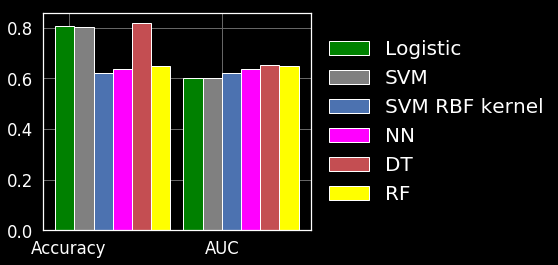

In [112]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style="white", context="notebook", font_scale=1.5, 
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})
#seaborn.set(style="ticks", context="talk")
plt.style.use("dark_background")
seaborn.set_style({'grid.color': '.4'})

'''
confusionArrayLogreg
#confusionArrayNN
confusionArraySVMNormal
confusionArraySVMPoly
confusionArraySvmKernel
confusionArrayRBFKernel
'''

legends = ['Logistic', 'SVM', 'SVM RBF kernel', 'NN', 'DT', 'RF']
fontSize = 20

fig, ax = plt.subplots()
numerOfVariables = 2
ind = np.arange(numerOfVariables)  
width = 0.15       # the width of the bars
rects2 = ax.bar(ind+1*width, np.asarray([confusionArrayLogreg[4], confusionArrayLogreg[5]]), width, color='green')
#rects3 = ax.bar(ind+2*width, np.asarray([confusionArraySVMNormal[4], confusionArraySVMNormal[5]]), width, color='grey')
rects3 = ax.bar(ind+2*width, np.asarray([confusionArraySVMNormalSoft[4], confusionArraySVMNormalSoft[5]]), 
                width, color='grey')
rects4 = ax.bar(ind+3*width, np.asarray([confusionArrayRBFKernel[5], confusionArrayRBFKernel[5]]), width, color='b')
rects5 = ax.bar(ind+4*width, np.asarray([confusionArrayNN[5], confusionArrayNN[5]]), width, color='magenta')
rects6 = ax.bar(ind+5*width, np.asarray([confusionArrayDT[4], confusionArrayDT[5]]), width, color='r')
rects7 = ax.bar(ind+6*width, np.asarray([confusionArrayRFHyperparameter[5], confusionArrayRFHyperparameter[5]]),
                width, color='yellow')
#ax.set_title(r'$Sd(\hat{\beta})/\hat{\beta},\;$ Noise term: %.2f' %self.noise)
ax.set_xticks((ind + width)*1.2 )#/ 2)
variableNames = ['Accuracy', 'AUC', 'True negative']
ax.set_xticklabels(variableNames)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(legends, loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = fontSize)

__Figure :__ Accuracy and AUC all classifiers. <br>
_The ranking of the classifiers depends highly on the performance measures. Some of the classifiers that performs best measured with accuracy, are performs the worst when measured with AUC._

We are most interested in the performance of prediciting the negatives correctly, i.e. the customers with defaults. We will now extend the figure above in order to also include the rate of correctly predicted defaults.

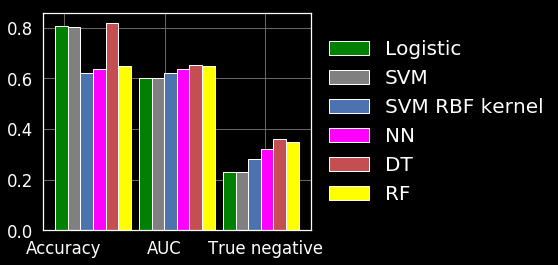

In [113]:
fig, ax = plt.subplots()
numerOfVariables = 3
ind = np.arange(numerOfVariables)  
width = 0.15       # the width of the bars
rects2 = ax.bar(ind+1*width, np.asarray([confusionArrayLogreg[4], confusionArrayLogreg[5], 
                                        confusionArrayLogreg[3][1,1]]), width, color='green')
rects3 = ax.bar(ind+2*width, np.asarray([confusionArraySVMNormalSoft[4], confusionArraySVMNormalSoft[5],
                                       confusionArraySVMNormalSoft[3][1,1]]), width, color='grey')
rects4 = ax.bar(ind+3*width, np.asarray([confusionArrayRBFKernel[5], confusionArrayRBFKernel[5],
                                        confusionArrayRBFKernel[3][1,1]]), width, color='b')
rects5 = ax.bar(ind+4*width, np.asarray([confusionArrayNN[5], confusionArrayNN[5],
                                        confusionArrayNN[3][1,1]]), width, color='magenta')
rects6 = ax.bar(ind+5*width, np.asarray([confusionArrayDT[4], confusionArrayDT[5],
                                        confusionArrayDT[3][1,1]]), width, color='r')
rects7 = ax.bar(ind+6*width, np.asarray([confusionArrayRFHyperparameter[5], confusionArrayRFHyperparameter[5],
                                        confusionArrayRFHyperparameter[3][1,1]]), width, color='yellow')
#ax.set_title(r'$Sd(\hat{\beta})/\hat{\beta},\;$ Noise term: %.2f' %self.noise)
ax.set_xticks((ind + width)*1.2 )#/ 2)
variableNames = ['Accuracy', 'AUC', 'True negative']
ax.set_xticklabels(variableNames)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(legends, loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = fontSize)

__Figure :__ Performance including rate of true negatives. All classifiers. <br>
_The AUC rankings corresponds better with the rankings of the the true neagtives than the accuracy score rankings._

Ok accuracy. Not impressing performance when it compes to predicting the defaults. Only a 3rd of the defaults in the test set is correctly predicted. <br>

Yeh and Lien (2009) get: <br>
Training accuracy: 0.81<br>
Training AUC: 0.55 <br>
Testing accuracy: 0.83<br>
Testing AUC: 0.54 <br>

We see that we get the accuracy the the same level as Yeh and Lien (2009), but the AUC is better. However, it is unclear wheteher it acutally is AUC Yeh and Lien (2009) applies, as they call it area ratio.<br>

Pyzhov and Pyzhov (2017) get about the same acuracy as we do, but higher AUCs.

## Ensamble learning
Enemble learning is when we combine different estimators. Ensemble learning has the potential to reudce both bias and variance. Predictors that perform poorly individually can, when combined, perform well. 

### Ensamle learning: The ensamble class
We will not apply Sci-Kit learns method for ensamble learning, the "VotingClassifier". The reason we will not apply VotingClassifier is that all the sub-classifiers are re-trained when the VotingClassifier is used. Hence tuned hyperparameters from former gridsearches are lost when applying VotingClassifier. We have seen that some of the results are quit dependent on the hyperparameters, so we want to keep the models fitted with the best hyperparameters. The EnsembleVoteClassifier from mlxtend.classifier allows us to perform ensamble learning with pre-fitted models, and this is the method we will apply.  

### Ensamble learning: Soft vs hard voting.
Soft and hard voting are two different methods used for creating an ensamble prediction. With soft voting the average of the of the prediction probabilities for each class is calculated and the class with highest average is chosen. With hard voting, the class with the majority of highest probabilities is chosen.

We will now show the effect on our results of the choice of voting type. We compare the the ensamble with all models from the text, which applied soft voting, to the same ensamble using hard voting.

/home/k/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/k/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/k/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


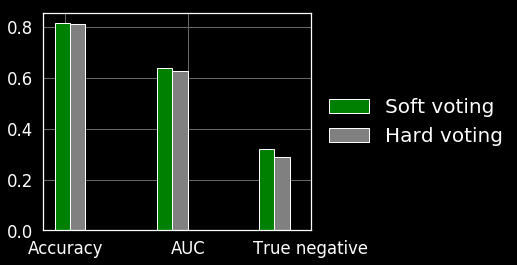

In [92]:
from mlxtend.classifier import EnsembleVoteClassifier

eclf = EnsembleVoteClassifier(clfs=[gridSearch, svmNormalSoft, svmKernelGridSearch, gsDT, rfHyperFinal, model], 
                              weights=[1,1,1,1,1,1],
                              refit=False, 
                              voting='hard')
eclf.fit(XTrain, yTrain)
confusionArrayEnsembleHard= createConfusionMatrix('eclf', printOut=False)

legends = ['Soft voting', 'Hard voting']
fontSize = 20

# Plot
fig, ax = plt.subplots()
numerOfVariables = 3
ind = np.arange(numerOfVariables)  
width = 0.15       # the width of the bars
rects2 = ax.bar(ind+1*width, np.asarray([confusionArrayEnsemble[4], confusionArrayEnsemble[5], 
                                        confusionArrayEnsemble[3][1,1]]), width, color='green')
rects3 = ax.bar(ind+2*width, np.asarray([confusionArrayEnsembleHard[4], confusionArrayEnsembleHard[5],
                                       confusionArrayEnsembleHard[3][1,1]]), width, color='grey')
#ax.set_title(r'$Sd(\hat{\beta})/\hat{\beta},\;$ Noise term: %.2f' %self.noise)
ax.set_xticks((ind + width)*1.2 )#/ 2)
variableNames = ['Accuracy', 'AUC', 'True negative']
ax.set_xticklabels(variableNames)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(legends, loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = fontSize)

__Figure :__ Soft vs hard voting. Ensamble of all models. <br>
_Soft voting performs better than hard voting on all measures._

### Ensamble learning: Different ensambles
The idea behing ensamble learning is that a combination of models can perform better than any of the sub-models making up the combination (ensamble). However, this is not always the case. If a sub-model has an accuracy of say 10 per cent, adding this model to an ensamble would probably not increase the ensamble performance. 

In order to study the effect of different sub-models on the ensamble model performance, we compare the performance of three different ensambles. The first ensamble consists of all models applied above. The second ensamble consists of all models applied except for the worst model with respect to AUC, the logistic classifier. Finally the third ensamble consists of all models applied except the best model with respect to AUC, the decision tree.

/home/k/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/k/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/k/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/k/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

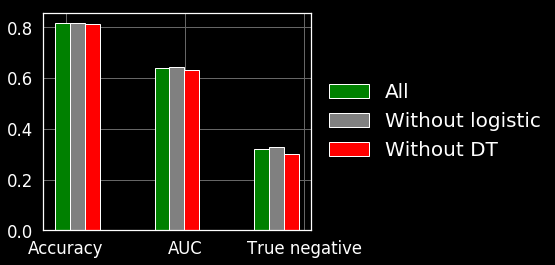

In [91]:
from mlxtend.classifier import EnsembleVoteClassifier

# All models
eclf = EnsembleVoteClassifier(clfs=[gridSearch, svmNormalSoft, svmKernelGridSearch, gsDT, rfHyperFinal, model], 
                              weights=[1,1,1,1,1,1],
                              refit=False, 
                              voting='soft')
eclf.fit(XTrain, yTrain)
confusionArrayEnsemble= createConfusionMatrix('eclf', printOut=False)


# Without Logistic
eclf = EnsembleVoteClassifier(clfs=[ svmNormalSoft,svmKernelGridSearch, model, gsDT, rfHyperFinal], 
                              weights=[1,1,1,1,1],
                              refit=False, 
                              voting='soft')
eclf.fit(XTrain, yTrain)
confusionArrayEnsembleNotLogistic= createConfusionMatrix('eclf', printOut=False)

# Without Dection tree
eclf = EnsembleVoteClassifier(clfs=[gridSearch, svmNormalSoft, svmKernelGridSearch, rfHyperFinal, model], 
                              weights=[1,1,1,1,1],
                              refit=False, 
                              voting='soft')
eclf.fit(XTrain, yTrain)
confusionArrayEnsembleNotDt= createConfusionMatrix('eclf', printOut=False)

# Plot
legends = ['All', 'Without logistic', 'Without DT']
fontSize = 20

fig, ax = plt.subplots()
numerOfVariables = 3
ind = np.arange(numerOfVariables)  
width = 0.15       # the width of the bars
rects2 = ax.bar(ind+1*width, np.asarray([confusionArrayEnsemble[4], confusionArrayEnsemble[5], 
                                        confusionArrayEnsemble[3][1,1]]), width, color='green')
rects3 = ax.bar(ind+2*width, np.asarray([confusionArrayEnsembleNotLogistic[4], confusionArrayEnsembleNotLogistic[5],
                                       confusionArrayEnsembleNotLogistic[3][1,1]]), width, color='grey')
rects4 = ax.bar(ind+3*width, np.asarray([confusionArrayEnsembleNotDt[4], confusionArrayEnsembleNotDt[5],
                                       confusionArrayEnsembleNotDt[3][1,1]]), width, color='red')
#ax.set_title(r'$Sd(\hat{\beta})/\hat{\beta},\;$ Noise term: %.2f' %self.noise)
ax.set_xticks((ind + width)*1.2 )#/ 2)
variableNames = ['Accuracy', 'AUC', 'True negative']
ax.set_xticklabels(variableNames)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(legends, loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = fontSize)

__Figure :__ Performance different ensambles. <br>
_More classifiers is not always better, and the quality of the classifiers affects the ensamble performance. Adding the worst classifier worsens the ensamble performance, while adding the best classifier increases the ensamble performance._

### Ensamble learning: Comparison to sub-models
We will now compare the results of the full ensamble to the results of all the sub-models.

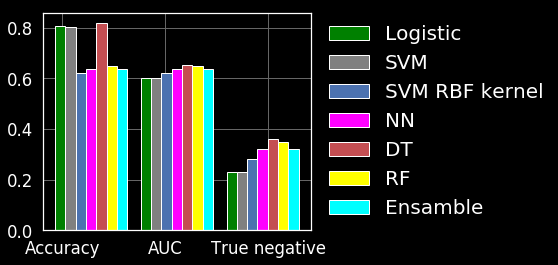

In [98]:
legends = ['Logistic', 'SVM', 'SVM RBF kernel', 'NN', 'DT', 'RF', 'Ensamble']
fontSize = 20

fig, ax = plt.subplots()
numerOfVariables = 3
ind = np.arange(numerOfVariables)  
width = 0.12      # the width of the bars
rects2 = ax.bar(ind+1*width, np.asarray([confusionArrayLogreg[4], confusionArrayLogreg[5], 
                                        confusionArrayLogreg[3][1,1]]), width, color='green')
rects3 = ax.bar(ind+2*width, np.asarray([confusionArraySVMNormalSoft[4], confusionArraySVMNormalSoft[5],
                                       confusionArraySVMNormalSoft[3][1,1]]), width, color='grey')
rects4 = ax.bar(ind+3*width, np.asarray([confusionArrayRBFKernel[5], confusionArrayRBFKernel[5],
                                        confusionArrayRBFKernel[3][1,1]]), width, color='b')
rects5 = ax.bar(ind+4*width, np.asarray([confusionArrayNN[5], confusionArrayNN[5],
                                        confusionArrayNN[3][1,1]]), width, color='magenta')
rects6 = ax.bar(ind+5*width, np.asarray([confusionArrayDT[4], confusionArrayDT[5],
                                        confusionArrayDT[3][1,1]]), width, color='r')
rects7 = ax.bar(ind+6*width, np.asarray([confusionArrayRFHyperparameter[5], confusionArrayRFHyperparameter[5],
                                        confusionArrayRFHyperparameter[3][1,1]]), width, color='yellow')
rects8 = ax.bar(ind+7*width, np.asarray([confusionArrayEnsemble[5], confusionArrayEnsemble[5],
                                        confusionArrayEnsemble[3][1,1]]), width, color='cyan')
#ax.set_title(r'$Sd(\hat{\beta})/\hat{\beta},\;$ Noise term: %.2f' %self.noise)
ax.set_xticks((ind + width)*1.2 )#/ 2)
variableNames = ['Accuracy', 'AUC', 'True negative']
ax.set_xticklabels(variableNames)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(legends, loc='center left', bbox_to_anchor=(1, 0.5)\
, fontsize = fontSize)

__Figure :__ Ensamble classifier and all sub-classifiers. <br>
_The ensamble classifier performs worse than several of the sub-classifiers._

# Conclusions

# References
Yeh, I-C. and Lien, C-h. (2009). The comparisons of data mining techniques for the predictive
accuracy of probability of default of credit card clients. <br>
_Expert Systems with Applications_ 36 (2009) 2473–2480. <br>
https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_05_classification_databases/2.1-lesson/assets/datasets/DefaultCreditCardClients_yeh_2009.pdf

Pyzhov, V. and Pyzhov, S. (2017). Comparison of methods of data mining
techniques for the predictive accuracy. _MPRA Paper_ No. 79326. <br>
https://mpra.ub.uni-muenchen.de/79326/1/MPRA_paper_79326.pdf

Geron, A. (2017). Hands-on machine learning with Sci-Kit learn and Tensorflow. O'Reilly.


/home/k/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/k/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/k/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


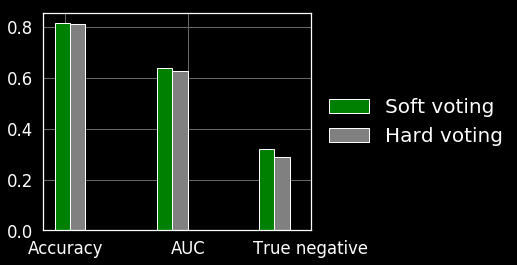

# Appendix 1: Code Sci-Kit learn ensamble learning

In [93]:
'''
from sklearn.ensemble import VotingClassifier

#('svmPoly', polynomial_svm_clf),
#('smvPolyKernel', smvPolyKernelGridSearch),
# nn model
#('svm', gridSearchSVMNormal),
votingClf = VotingClassifier(
                            estimators = [('lr', gridSearch), 
                                          ('svmKernel', svmKernelGridSearch),
                                          ('rf', rfHyperFinal)],
                            voting='hard')
votingClf.fit(XTrain, yTrain)
'''

"\nfrom sklearn.ensemble import VotingClassifier\n\n#('svmPoly', polynomial_svm_clf),\n#('smvPolyKernel', smvPolyKernelGridSearch),\n# nn model\n#('svm', gridSearchSVMNormal),\nvotingClf = VotingClassifier(\n                            estimators = [('lr', gridSearch), \n                                          ('svmKernel', svmKernelGridSearch),\n                                          ('rf', rfHyperFinal)],\n                            voting='hard')\nvotingClf.fit(XTrain, yTrain)\n"

In [ ]:
#confusionArrayEnsemble= createConfusionMatrix('votingClf')

In [ ]:
'''
from sklearn.ensemble import VotingClassifier

#('svmPoly', polynomial_svm_clf),
#('smvPolyKernel', smvPolyKernelGridSearch),
# nn model
#('svm', gridSearchSVMNormal),
votingClf = VotingClassifier(
                            estimators = [('lr', gridSearch), 
                                          ('svmKernel', svmKernelGridSearch),
                                          ('rf', rfHyperFinal)],
                            voting='soft')
votingClf.fit(XTrain, yTrain)
'''

In [ ]:
#confusionArrayEnsemble= createConfusionMatrix('votingClf')

In [ ]:
'''
from sklearn.ensemble import VotingClassifier

#('svmPoly', polynomial_svm_clf),
#('smvPolyKernel', smvPolyKernelGridSearch),
# nn model
#('svm', gridSearchSVMNormal),
votingClfNN = VotingClassifier(
                            estimators = [('lr', gridSearch), 
                                          ('svmKernel', svmKernelGridSearch),
                                          ('rf', rfHyperFinal),
                                          ('nn', model)],
                            voting='soft')
votingClfNN.fit(XTrain, yTrain.ravel())
'''

In [ ]:
#confusionArrayEnsemble= createConfusionMatrix('votingClfNN')

# Appendix 2:  PCA

We will explore the effects of training the network with principcal components. For many of the networks we do not expect the introduction of principcal components to improve the performance considerably. The difference between training and testing accuracy is small for many of the networks, indicating that there is little overfitting. Maybe for the network setuos where there are larger deviations between training and testing accuracy, the networks with mutiple hidden layers, there can be gains from introducing principcal components. 

We use the principal components that explain 95 per cent of total variance.

In [99]:
'''

from sklearn.decomposition import PCA



pca = PCA(n_components = 0.95)
Xreduced = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
'''

'\n\nfrom sklearn.decomposition import PCA\n\n\n\npca = PCA(n_components = 0.95)\nXreduced = pca.fit_transform(X)\nprint(pca.explained_variance_ratio_)\nprint(np.sum(pca.explained_variance_ratio_))\n'

In [100]:
'''
trainingShare = 0.5 
XTrain, XTest, yTrain, yTest=train_test_split(Xreduced, y, train_size=trainingShare, \
                                              test_size = 1-trainingShare)
Y_train_onehot, Y_test_onehot = to_categorical(yTrain), to_categorical(yTest)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu', input_dim=XTrain.shape[1]))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(Y_train_onehot.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model.summary())

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             min_delta = 0,
                                             patience=5,
                                             verbose=0,
                                             mode='auto')]


history = model.fit(XTrain,
                    Y_train_onehot, 
                    epochs=100, 
                    batch_size=30,
                    validation_data=[XTest, Y_test_onehot],
                    callbacks = callbacks)
'''

"\ntrainingShare = 0.5 \nXTrain, XTest, yTrain, yTest=train_test_split(Xreduced, y, train_size=trainingShare,                                               test_size = 1-trainingShare)\nY_train_onehot, Y_test_onehot = to_categorical(yTrain), to_categorical(yTest)\nmodel = tf.keras.Sequential()\nmodel.add(tf.keras.layers.Dense(50, activation='relu', input_dim=XTrain.shape[1]))\nmodel.add(tf.keras.layers.Dense(50, activation='relu'))\nmodel.add(tf.keras.layers.Dense(50, activation='relu'))\nmodel.add(tf.keras.layers.Dense(50, activation='relu'))\nmodel.add(tf.keras.layers.Dense(50, activation='relu'))\nmodel.add(tf.keras.layers.Dense(Y_train_onehot.shape[1], activation='softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])\nprint(model.summary())\n\ncallbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',\n                                             min_delta = 0,\n                                             patience=5,\n            

We see that both training and testing accuracy is reduced when using Principal components as predictors instead of all of the original features. However, we also observe that the difference between training and validation accuracy is smaller when using principal components as predictors instead of all the features from the original data set.

## Kernel PCA
We will try Sci-Kit learn's kernel PCA method. Kernel PCA, kPca, is a PCA-method that allows for non-linearity. <mark> More about this!
    

In [101]:
'''
from sklearn.decomposition import KernelPCA, TruncatedSVD
kPCA = KernelPCA(n_components=2, kernel='rbf', gamma=10) #0.04
#kPCA = TruncatedSVD(n_components=5, algorithm='arpack')
X_reduced = kPCA.fit_transform(X)
print(kPCA.explained_variance_ratio_)
print(np.sum(kPCA.explained_variance_ratio_))
'''

"\nfrom sklearn.decomposition import KernelPCA, TruncatedSVD\nkPCA = KernelPCA(n_components=2, kernel='rbf', gamma=10) #0.04\n#kPCA = TruncatedSVD(n_components=5, algorithm='arpack')\nX_reduced = kPCA.fit_transform(X)\nprint(kPCA.explained_variance_ratio_)\nprint(np.sum(kPCA.explained_variance_ratio_))\n"

kPCA did not work. It gave memory error.

# Appendix 3: Polynomial and kernel SVM
### Polynomial SVM
Increasing the complexity by introducing polynomial variables may increase the quality of the separation. We will not perform an polynomial SVM-estimation where we use second degree polynomials.

In [ ]:
'''
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(XTrain, yTrain.ravel())
'''

In [ ]:
#confusionArraySVMPoly = createConfusionMatrix('polynomial_svm_clf')

The resuls with the 2nd degree polynomial are worse than with the normal SVM. Only a fourth of the customers with defauls is correctly predicted. Higher degree polynomial might work better. 
### SVM: Polynomial kernel
The computational cost quickly becomes large for higher degree polynomials. 

A remedy is to use the so-called Kernel trick to effectively apply higher degree polynomials. With the kernel-trick we get higher degree polynomials without the extra computational cost!

In [ ]:
'''
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svmPolynomialKernel = SVC(kernel='poly')
parameters = [{'degree': np.array((2,3)), 'C': [1.0]},
              {'C':np.logspace(-1,1,3), 'degree': [3]}]
scoring = ['accuracy', 'roc_auc']
folds = 5
smvPolyKernelGridSearch = GridSearchCV(svmPolynomialKernel, cv = folds, param_grid=parameters, scoring=scoring,
                                       refit='roc_auc')
smvPolyKernelGridSearchResult = smvPolyKernelGridSearch.fit(XTrain, yTrain.ravel())
'''

In [ ]:
#gridSearchSummary('smvPolyKernelGridSearchResult', 'auc')

Three degrees works better than ten degrees. The AUC is higher for three degrees than for ten degrees.

In [ ]:
#smvPolyKernelGridSearchResult.cv_results_

In [ ]:
#confusionArraySvmKernel = createConfusionMatrix('smvPolyKernelGridSearchResult')

There was a gain increasing the degree from two, which we used with standard polynomial SVM, to three, which was the best degree found with polynomial kernel. The result is close to the result for standard SVM.